# Experiment 1: Prompt Enhancement with Genetic Algorithms

## Goal
Evolve a basic prompt into an enhanced prompt using genetic algorithms.

## Methodology
- **Genome**: PromptGenome (base_prompt + positive_modifiers + negative_modifiers)
- **Fitness**: w1 * CLIP_score + w2 * Aesthetic_score
- **Model**: flux-schnell (Fal AI)

## Sub-experiments
- **1.1 Static Weights**: Fixed CLIP=0.6, Aesthetic=0.4 throughout evolution
- **1.2 Adaptive Weights**: CLIP weight decreases from 0.8 → 0.4 over generations

---

## Cell 1: Setup & Imports

In [1]:
# Standard library imports
import sys
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Add parent directory to path for src imports
sys.path.insert(0, '..')

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import scipy.stats as stats

# Project imports
from src.genome import PromptGenome, GenomeFactory
from src.evolution import GeneticOperators, EvolutionEngine
from src.fitness import FitnessEvaluator, AdaptiveFitnessEvaluator
from src.models import get_model
from src.vocabulary_manager import VocabularyManager
from src.utils import (
    create_modifier_vocab, 
    create_negative_vocab, 
    save_json,
    Logger
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Enable inline plotting
%matplotlib inline

print("Environment setup complete.")
print(f"Random seed: {RANDOM_SEED}")
print(f"Working directory: {os.getcwd()}")

Environment setup complete.
Random seed: 42
Working directory: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/experiments


## Cell 2: Configuration

In [2]:
# =============================================================================
# EXPERIMENT PARAMETERS (ENHANCED)
# =============================================================================

# Base prompt to evolve
BASE_PROMPT = "a tiger in the jungle"

# Evolution parameters - INCREASED for better results
POPULATION_SIZE = 10
MAX_GENERATIONS = 20

# Vocabulary Manager parameters
USE_VOCABULARY_MANAGER = True  # Enable LLM-based adaptive vocabulary
VOCAB_INITIAL_SIZE = 1000  # Target size for initial vocabulary
VOCAB_EXPANSION_SIZE = 50  # New modifiers to add per expansion
VOCAB_PRUNE_THRESHOLD = 20  # Generations before pruning unused modifiers
VOCAB_EXPANSION_INTERVAL = 5  # Expand vocabulary every N generations
VOCAB_PRUNE_INTERVAL = 10  # Prune vocabulary every N generations
ELITE_SIZE = 2
MUTATION_RATE = 0.5
ADD_PROBABILITY = 0.35
REMOVE_PROBABILITY = 0.2

# Genome constraints - EXPANDED search space
MAX_POSITIVE_MODIFIERS = 12
MAX_NEGATIVE_MODIFIERS = 6

# =============================================================================
# FITNESS WEIGHTS
# =============================================================================

# Static weights (Experiment 1.1)
STATIC_CLIP_WEIGHT = 0.6
STATIC_AESTHETIC_WEIGHT = 0.4

# Adaptive weights (Experiment 1.2)
# Strategy: Start with semantic alignment, shift to aesthetic focus
INITIAL_CLIP_WEIGHT = 0.8  # Early: prioritize CLIP (semantic alignment)
FINAL_CLIP_WEIGHT = 0.4    # Late: prioritize aesthetics

# =============================================================================
# MODEL SETTINGS
# =============================================================================

MODEL_NAME = "flux-schnell"
IMAGE_SIZE = "landscape_4_3"
NUM_INFERENCE_STEPS = 4
GENERATION_SEED = 42  # Fixed seed for reproducible image generation

# =============================================================================
# OUTPUT SETTINGS
# =============================================================================

OUTPUT_DIR = Path("../data/results/experiment_1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_EVERY_N_GENERATIONS = 5  # Save checkpoints every N generations
SAVE_ALL_IMAGES = True  # NEW: Save all generated images

# =============================================================================
# RESULTS TRACKING
# =============================================================================

# Global array to store all results
ALL_RESULTS = []

# Print configuration summary
print("=" * 60)
print("EXPERIMENT 1 CONFIGURATION (ENHANCED)")
print("=" * 60)
print(f"\nBase Prompt: {BASE_PROMPT}")
print(f"\nEvolution Parameters:")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Max Generations: {MAX_GENERATIONS}")
print(f"  Elite Size: {ELITE_SIZE}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print(f"  Max Positive Modifiers: {MAX_POSITIVE_MODIFIERS}")
print(f"  Max Negative Modifiers: {MAX_NEGATIVE_MODIFIERS}")
print(f"\nStatic Weights (Exp 1.1):")
print(f"  CLIP: {STATIC_CLIP_WEIGHT}, Aesthetic: {STATIC_AESTHETIC_WEIGHT}")
print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  CLIP: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"\nModel: {MODEL_NAME}")
print(f"Save All Images: {SAVE_ALL_IMAGES}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 60)

EXPERIMENT 1 CONFIGURATION (ENHANCED)

Base Prompt: a tiger in the jungle

Evolution Parameters:
  Population Size: 10
  Max Generations: 20
  Elite Size: 2
  Mutation Rate: 0.5
  Max Positive Modifiers: 12
  Max Negative Modifiers: 6

Static Weights (Exp 1.1):
  CLIP: 0.6, Aesthetic: 0.4

Adaptive Weights (Exp 1.2):
  CLIP: 0.8 -> 0.4

Model: flux-schnell
Save All Images: True
Output Directory: ../data/results/experiment_1


## Cell 3: Initialize Components

In [3]:
# =============================================================================
# INITIALIZE MODEL
# =============================================================================
print("Initializing image generation model...")
model = get_model(MODEL_NAME)
print(f"  Model: {MODEL_NAME} initialized")

# =============================================================================
# CREATE VOCABULARIES
# =============================================================================
print("\nCreating vocabularies...")

# Initialize VocabularyManager if enabled
vocab_manager = None
if USE_VOCABULARY_MANAGER:
    print("\nInitializing VocabularyManager with LLM...")
    vocab_manager = VocabularyManager(
        use_llm=True,
        initial_size=VOCAB_INITIAL_SIZE,
        expansion_size=VOCAB_EXPANSION_SIZE,
        prune_threshold=VOCAB_PRUNE_THRESHOLD
    )
    
    # Initialize vocabulary with domain description
    domain_description = f"image generation for: {BASE_PROMPT}"
    block_vocabularies = vocab_manager.initialize_vocabulary(
        reference_image=None,
        domain_description=domain_description
    )
    
    # Convert block vocabularies to flat lists for Experiment 1
    # Combine all positive blocks into one list
    modifier_vocab = []
    for block_name in ["composition", "lighting", "style", "quality"]:
        modifier_vocab.extend(block_vocabularies.get(block_name, []))
    
    negative_vocab = block_vocabularies.get("negative", [])
    
    print(f"\n  LLM-generated vocabulary:")
    print(f"  Positive modifiers: {len(modifier_vocab)} terms")
    print(f"  Negative modifiers: {len(negative_vocab)} terms")
    print(f"  Synonym mappings: {len(vocab_manager.synonym_map)}")
else:
    # Fallback to static vocabulary
    modifier_vocab = create_modifier_vocab()
    negative_vocab = create_negative_vocab()
    print(f"  Static vocabulary:")
    print(f"  Positive modifiers: {len(modifier_vocab)} terms")
    print(f"  Negative modifiers: {len(negative_vocab)} terms")

# Preview some modifiers
print(f"\n  Sample positive modifiers: {modifier_vocab[:5]}")
print(f"  Sample negative modifiers: {negative_vocab[:5]}")

# =============================================================================
# CREATE GENOME FACTORY
# =============================================================================
print("\nCreating genome factory...")
factory = GenomeFactory(
    modifier_vocab=modifier_vocab,
    negative_vocab=negative_vocab,
    max_positive_modifiers=MAX_POSITIVE_MODIFIERS,
    max_negative_modifiers=MAX_NEGATIVE_MODIFIERS
)
print(f"  Max positive modifiers: {MAX_POSITIVE_MODIFIERS}")
print(f"  Max negative modifiers: {MAX_NEGATIVE_MODIFIERS}")

# =============================================================================
# CREATE GENETIC OPERATORS
# =============================================================================
print("\nCreating genetic operators...")
operators = GeneticOperators(
    factory=factory,
    vocabulary_manager=vocab_manager,  # Enable synonym-aware mutation
    mutation_rate=MUTATION_RATE,
    add_probability=ADD_PROBABILITY,
    remove_probability=REMOVE_PROBABILITY
)
print(f"  Mutation rate: {MUTATION_RATE}")
print(f"  Add probability: {ADD_PROBABILITY}")
print(f"  Remove probability: {REMOVE_PROBABILITY}")

# =============================================================================
# CREATE EVOLUTION ENGINE
# =============================================================================
print("\nCreating evolution engine...")
engine = EvolutionEngine(
    factory=factory,
    operators=operators,
    population_size=POPULATION_SIZE,
    elite_size=ELITE_SIZE,
    selection_method="tournament"
)
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Elite size: {ELITE_SIZE}")
print(f"  Selection method: tournament")

# =============================================================================
# CREATE FITNESS EVALUATORS
# =============================================================================
print("\nCreating fitness evaluators...")

# Static fitness evaluator (Experiment 1.1)
static_evaluator = FitnessEvaluator(
    clip_weight=STATIC_CLIP_WEIGHT,
    aesthetic_weight=STATIC_AESTHETIC_WEIGHT
)
print(f"  Static Evaluator: CLIP={STATIC_CLIP_WEIGHT}, Aesthetic={STATIC_AESTHETIC_WEIGHT}")

# Adaptive fitness evaluator (Experiment 1.2)
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)
print(f"  Adaptive Evaluator: CLIP {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")

# =============================================================================
# INITIALIZE LOGGER
# =============================================================================
logger = Logger(log_dir=str(OUTPUT_DIR / "logs"), name="experiment_1")
logger.info("Experiment 1 components initialized")

print("\n" + "=" * 60)
print("ALL COMPONENTS INITIALIZED SUCCESSFULLY")
print("=" * 60)

Initializing image generation model...
  Model: flux-schnell initialized

Creating vocabularies...

Initializing VocabularyManager with LLM...


/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


VocabularyManager: Initialized Gemini (project: hubx-ml-playground)

INITIALIZING VOCABULARY
Target size: 1000 modifiers
Domain: image generation for: a tiger in the jungle
LLM enabled: True
Generating vocabulary...

INITIAL VOCABULARY:
  composition :  193 modifiers
  lighting    :  205 modifiers
  style       :  244 modifiers
  quality     :  185 modifiers
  negative    :  248 modifiers
  TOTAL       : 1075 modifiers
  Synonym mappings: 52


  LLM-generated vocabulary:
  Positive modifiers: 827 terms
  Negative modifiers: 248 terms
  Synonym mappings: 52

  Sample positive modifiers: ['wide shot', 'medium shot', 'close-up', 'extreme close-up', 'long shot']
  Sample negative modifiers: ['blurry', 'grainy', 'noisy', 'pixelated', 'low resolution']

Creating genome factory...
  Max positive modifiers: 12
  Max negative modifiers: 6

Creating genetic operators...
  Mutation rate: 0.5
  Add probability: 0.35
  Remove probability: 0.2

Creating evolution engine...
  Population size: 10
  El

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully
  Static Evaluator: CLIP=0.6, Aesthetic=0.4
Initializing CLIP model on cpu...


2025-12-30 16:08:26,068 - experiment_1 - INFO - Experiment 1 components initialized


CLIP model loaded successfully
  Adaptive Evaluator: CLIP 0.8 -> 0.4

ALL COMPONENTS INITIALIZED SUCCESSFULLY


## Cell 4: Baseline Evaluation

Generating baseline image (no modifiers)...
Prompt: a tiger in the jungle

Baseline genome: PromptGenome(fitness=0.000, prompt='a tiger in the jungle')
Baseline image generated successfully.

Evaluating baseline fitness...
CLIP score: 0.6552
Aesthetic score: 0.7900
Weighted fitness: 0.7091

Baseline Fitness Score: 0.7091
Baseline image saved to: ../data/results/experiment_1/baseline_image.jpg


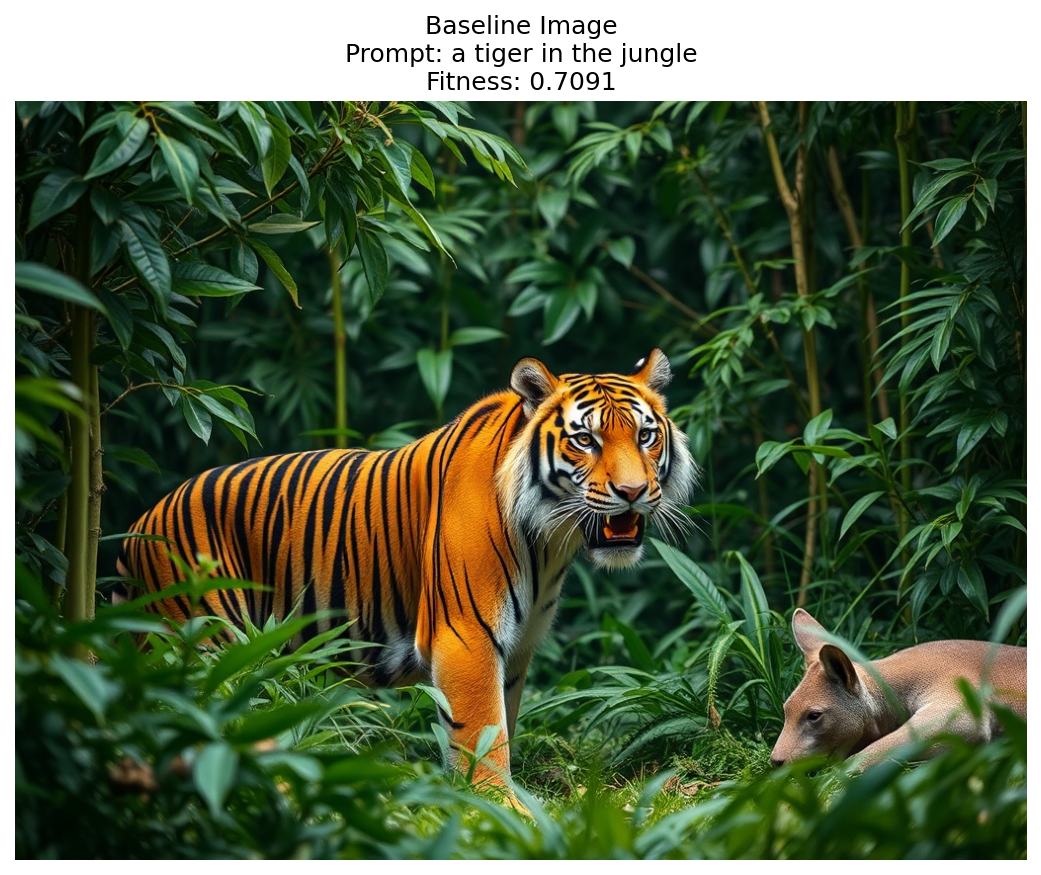

2025-12-30 16:08:42,441 - experiment_1 - INFO - Baseline evaluation complete. Score: 0.7091


In [4]:
# =============================================================================
# GENERATE AND EVALUATE BASELINE
# =============================================================================
print("Generating baseline image (no modifiers)...")
print(f"Prompt: {BASE_PROMPT}")
print()

# Create baseline genome (empty modifiers)
baseline_genome = factory.create_empty(BASE_PROMPT)
print(f"Baseline genome: {baseline_genome}")

# Generate baseline image
try:
    baseline_image, baseline_metadata = model.generate(
        prompt=baseline_genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=GENERATION_SEED
    )
    print("Baseline image generated successfully.")
except Exception as e:
    print(f"Error generating baseline image: {e}")
    raise

# Evaluate baseline fitness using static evaluator
print("\nEvaluating baseline fitness...")
baseline_score = static_evaluator.evaluate(
    image=baseline_image, 
    text=BASE_PROMPT, 
    verbose=True
)
print(f"\nBaseline Fitness Score: {baseline_score:.4f}")

# Save baseline image
baseline_path = OUTPUT_DIR / "baseline_image.jpg"
baseline_image.save(baseline_path)
print(f"Baseline image saved to: {baseline_path}")

# Display baseline image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(baseline_image)
ax.set_title(f"Baseline Image\nPrompt: {BASE_PROMPT}\nFitness: {baseline_score:.4f}", fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "baseline_display.png")
plt.show()

# Log baseline results
logger.info(f"Baseline evaluation complete. Score: {baseline_score:.4f}")

## Cell 5: Helper Functions

In [5]:
# Helper function to convert numpy types to native Python types
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.floating)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64, np.integer)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj


def prompt_genome_to_block_format(genome: PromptGenome) -> Dict[str, List[str]]:
    """
    Convert PromptGenome to block format for VocabularyManager.
    
    Args:
        genome: PromptGenome instance
        
    Returns:
        Dictionary with block structure
    """
    # For Experiment 1, we distribute positive_modifiers across blocks
    # This is a simple heuristic - in practice, you might want smarter categorization
    block_format = {
        "composition": [],
        "lighting": [],
        "style": [],
        "quality": [],
        "negative": list(genome.negative_modifiers)
    }
    
    # Distribute positive modifiers (simple heuristic: check if in vocab blocks)
    if vocab_manager:
        for modifier in genome.positive_modifiers:
            # Try to find which block this modifier belongs to
            found = False
            for block_name in ["composition", "lighting", "style", "quality"]:
                if modifier in vocab_manager.vocabularies.get(block_name, []):
                    block_format[block_name].append(modifier)
                    found = True
                    break
            # If not found in any block, default to style
            if not found:
                block_format["style"].append(modifier)
    else:
        # Fallback: put all in style
        block_format["style"] = list(genome.positive_modifiers)
    
    return block_format


def update_vocabulary_from_genome(genome: PromptGenome, vocab_manager: VocabularyManager):
    """Track usage of modifiers in a PromptGenome"""
    if vocab_manager:
        block_format = prompt_genome_to_block_format(genome)
        # Create a temporary BlockGenome-like object for tracking
        class TempBlock:
            def __init__(self, blocks):
                self.composition = blocks.get("composition", [])
                self.lighting = blocks.get("lighting", [])
                self.style = blocks.get("style", [])
                self.quality = blocks.get("quality", [])
                self.negative = blocks.get("negative", [])
        
        temp = TempBlock(block_format)
        vocab_manager.track_usage(temp)


def run_experiment(
    evaluator: FitnessEvaluator,
    experiment_name: str,
    results_array: List[Dict],
    max_generations: int = MAX_GENERATIONS,
    save_every: int = SAVE_EVERY_N_GENERATIONS,
    is_adaptive: bool = False,
    save_all_images: bool = SAVE_ALL_IMAGES
) -> Tuple[Dict[str, Any], List[PromptGenome]]:
    """
    Run one complete evolutionary experiment with comprehensive image saving.
    
    Args:
        evaluator: Fitness evaluator (static or adaptive)
        experiment_name: Name for saving results
        results_array: List to store all results (prompts, images, fitness)
        max_generations: Maximum number of generations
        save_every: Save checkpoint every N generations
        is_adaptive: Whether using adaptive evaluator
        save_all_images: Whether to save all generated images
    
    Returns:
        history: Dict with fitness tracking per generation
        final_population: Final evolved population
    """
    # Create experiment output directory
    exp_dir = OUTPUT_DIR / experiment_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    # Create images directory for all images
    images_dir = exp_dir / "all_images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': [],
        'diversity': [],
        'best_prompts': [],
        'clip_weights': [],
        'aesthetic_weights': []
    }
    
    # Initialize population
    print(f"Initializing population of {POPULATION_SIZE} genomes...")
    population = engine.initialize_population(BASE_PROMPT)
    
    # Evolution loop
    for generation in range(max_generations):
        print(f"\n--- Generation {generation + 1}/{max_generations} ---")
        
        # Update adaptive weights if using adaptive evaluator
        if is_adaptive:
            evaluator.update_generation(generation)
            current_clip_weight = evaluator.clip_weight
            current_aesthetic_weight = evaluator.aesthetic_weight
        else:
            current_clip_weight = STATIC_CLIP_WEIGHT
            current_aesthetic_weight = STATIC_AESTHETIC_WEIGHT
        
        history['clip_weights'].append(float(current_clip_weight))
        history['aesthetic_weights'].append(float(current_aesthetic_weight))
        
        print(f"Weights: CLIP={current_clip_weight:.2f}, Aesthetic={current_aesthetic_weight:.2f}")
        
        # Evaluate fitness for all genomes
        gen_images = []
        for idx, genome in enumerate(tqdm(population, desc="Evaluating population")):
            try:
                # Generate image
                image, metadata = model.generate(
                    prompt=genome.to_prompt(),
                    image_size=IMAGE_SIZE,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    seed=GENERATION_SEED + generation * 100 + idx
                )
                
                # Evaluate fitness
                genome.fitness = evaluator.evaluate(image, BASE_PROMPT)
                gen_images.append((genome.fitness, image, genome.to_prompt(), genome))
                
                # Track vocabulary usage for VocabularyManager
                if vocab_manager:
                    update_vocabulary_from_genome(genome, vocab_manager)
                
                # Save image with generation index and fitness score
                if save_all_images:
                    img_filename = f"gen{generation+1:03d}_idx{idx:02d}_fit{float(genome.fitness):.4f}.jpg"
                    img_path = images_dir / img_filename
                    image.save(img_path)
                
                # Add to results array
                result_entry = {
                    'experiment': experiment_name,
                    'generation': generation + 1,
                    'individual_index': idx,
                    'prompt': genome.to_prompt(),
                    'negative_prompt': genome.get_negative_prompt(),
                    'positive_modifiers': genome.positive_modifiers.copy(),
                    'negative_modifiers': genome.negative_modifiers.copy(),
                    'fitness': float(genome.fitness),
                    'image_path': str(img_path) if save_all_images else None,
                    'clip_weight': float(current_clip_weight),
                    'aesthetic_weight': float(current_aesthetic_weight)
                }
                results_array.append(result_entry)
                
            except Exception as e:
                print(f"Error evaluating genome {idx}: {e}")
                genome.fitness = 0.0
        
        # Track fitness statistics
        fitnesses = [g.fitness for g in population]
        best_fitness = float(max(fitnesses))
        avg_fitness = float(np.mean(fitnesses))
        worst_fitness = float(min(fitnesses))
        diversity = float(engine.get_diversity(population))
        
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['worst_fitness'].append(worst_fitness)
        history['diversity'].append(diversity)
        
        # Get best genome
        best_genome = engine.get_best(population)
        history['best_prompts'].append(best_genome.to_prompt())
        
        print(f"Best: {best_fitness:.4f} | Avg: {avg_fitness:.4f} | Diversity: {diversity:.2f}")
        print(f"Best prompt: {best_genome.to_prompt()[:80]}...")
        
        # =====================================================================
        # ADAPTIVE VOCABULARY MANAGEMENT
        # =====================================================================
        if vocab_manager and generation < max_generations - 1:
            # Vocabulary Expansion: Every N generations, expand based on best prompts
            if (generation + 1) % VOCAB_EXPANSION_INTERVAL == 0:
                # Get top 5 genomes
                sorted_pop = sorted(population, key=lambda g: g.fitness, reverse=True)
                top_genomes = sorted_pop[:5]
                
                # Convert to block format
                best_prompts = [prompt_genome_to_block_format(g) for g in top_genomes]
                fitness_scores = [g.fitness for g in top_genomes]
                
                # Expand vocabulary
                new_terms = vocab_manager.expand_vocabulary(
                    best_prompts=best_prompts,
                    current_generation=generation + 1,
                    fitness_scores=fitness_scores
                )
                
                # Update modifier_vocab and negative_vocab from expanded vocabulary
                if new_terms:
                    modifier_vocab = []
                    for block_name in ["composition", "lighting", "style", "quality"]:
                        modifier_vocab.extend(vocab_manager.vocabularies.get(block_name, []))
                    negative_vocab = vocab_manager.vocabularies.get("negative", [])
                    
                    # Update factory with new vocabulary
                    factory.modifier_vocab = modifier_vocab
                    factory.negative_vocab = negative_vocab
                    print(f"  Updated vocabulary: {len(modifier_vocab)} positive, {len(negative_vocab)} negative")
            
            # Vocabulary Pruning: Every N generations, remove unused modifiers
            if (generation + 1) % VOCAB_PRUNE_INTERVAL == 0:
                pruned_count = vocab_manager.prune_vocabulary(current_generation=generation + 1)
                
                if pruned_count > 0:
                    # Update modifier_vocab and negative_vocab after pruning
                    modifier_vocab = []
                    for block_name in ["composition", "lighting", "style", "quality"]:
                        modifier_vocab.extend(vocab_manager.vocabularies.get(block_name, []))
                    negative_vocab = vocab_manager.vocabularies.get("negative", [])
                    
                    # Update factory with pruned vocabulary
                    factory.modifier_vocab = modifier_vocab
                    factory.negative_vocab = negative_vocab
                    print(f"  Updated vocabulary after pruning: {len(modifier_vocab)} positive, {len(negative_vocab)} negative")
        
        # Save checkpoint
        if (generation + 1) % save_every == 0 or generation == max_generations - 1:
            checkpoint_dir = exp_dir / f"gen_{generation + 1:02d}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            # Save best image
            if gen_images:
                gen_images.sort(key=lambda x: x[0], reverse=True)
                best_img = gen_images[0][1]
                best_img.save(checkpoint_dir / "best_image.jpg")
            
            # Save checkpoint data (convert to native types)
            checkpoint_data = {
                'generation': generation + 1,
                'best_fitness': best_fitness,
                'avg_fitness': avg_fitness,
                'best_prompt': best_genome.to_prompt(),
                'best_modifiers': best_genome.positive_modifiers,
                'best_negative': best_genome.negative_modifiers
            }
            save_json(to_native(checkpoint_data), str(checkpoint_dir / "checkpoint.json"))
            print(f"Checkpoint saved to {checkpoint_dir}")
        
        # Evolve to next generation (except on last generation)
        if generation < max_generations - 1:
            population = engine.evolve_generation(population)
    
    # Save final results (convert to native types)
    final_results = {
        'experiment_name': experiment_name,
        'generations': max_generations,
        'final_best_fitness': history['best_fitness'][-1],
        'final_avg_fitness': history['avg_fitness'][-1],
        'history': to_native(history)
    }
    save_json(final_results, str(exp_dir / "final_results.json"))
    
    logger.info(f"{experiment_name} complete. Best fitness: {history['best_fitness'][-1]:.4f}")
    
    return history, population


def visualize_results(history: Dict[str, List], baseline_score: float, title: str = "Evolution Progress"):
    """
    Create publication-quality convergence plot.
    """
    generations = range(1, len(history['best_fitness']) + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(generations, history['best_fitness'], 'g-', linewidth=2, 
            label='Best Fitness', marker='o', markersize=4)
    ax.plot(generations, history['avg_fitness'], 'b--', linewidth=1.5,
            label='Average Fitness', alpha=0.8)
    ax.fill_between(generations, history['worst_fitness'], history['best_fitness'],
                    alpha=0.2, color='green', label='Fitness Range')
    
    ax.axhline(y=baseline_score, color='orange', linestyle='-.', 
               linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(generations))
    
    y_min = min(min(history['worst_fitness']), baseline_score) * 0.95
    y_max = max(history['best_fitness']) * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig


def compare_experiments(
    exp1_history: Dict[str, List],
    exp2_history: Dict[str, List],
    baseline_score: float,
    exp1_name: str = "Static Weights",
    exp2_name: str = "Adaptive Weights"
):
    """
    Create side-by-side comparison plot for two experiments.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = range(1, len(exp1_history['best_fitness']) + 1)
    
    ax1 = axes[0]
    ax1.plot(generations, exp1_history['best_fitness'], 'b-', linewidth=2,
             label=f'{exp1_name} (Best)', marker='o', markersize=4)
    ax1.plot(generations, exp2_history['best_fitness'], 'r-', linewidth=2,
             label=f'{exp2_name} (Best)', marker='s', markersize=4)
    ax1.axhline(y=baseline_score, color='orange', linestyle='-.', 
                linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness Score')
    ax1.set_title('Best Fitness Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(generations, exp1_history['clip_weights'], 'b--', linewidth=2,
             label=f'{exp1_name} CLIP Weight')
    ax2.plot(generations, exp2_history['clip_weights'], 'r-', linewidth=2,
             label=f'{exp2_name} CLIP Weight')
    ax2.plot(generations, exp2_history['aesthetic_weights'], 'r:', linewidth=2,
             label=f'{exp2_name} Aesthetic Weight')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Weight Value')
    ax2.set_title('Fitness Weight Evolution')
    ax2.legend(loc='center right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig


def generate_final_image(genome: PromptGenome, seed: int = GENERATION_SEED) -> Tuple[Image.Image, float]:
    """
    Generate final image for a genome with consistent seed.
    """
    image, _ = model.generate(
        prompt=genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=seed
    )
    fitness = static_evaluator.evaluate(image, BASE_PROMPT)
    return image, float(fitness)


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Cell 6: Run Experiment 1.1 (Static Weights)

In [6]:
print("=" * 60)
print("EXPERIMENT 1.1: STATIC WEIGHTS")
print(f"CLIP Weight: {STATIC_CLIP_WEIGHT} (fixed)")
print(f"Aesthetic Weight: {STATIC_AESTHETIC_WEIGHT} (fixed)")
print("=" * 60)

# Run experiment with static weights
static_history, static_population = run_experiment(
    evaluator=static_evaluator,
    experiment_name="exp1_1_static",
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=False
)

# Get best genome from static experiment
best_static_genome = max(static_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.1 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_static_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_static_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_static_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_static_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_static_genome.negative_modifiers}")
print(f"\nTotal images generated so far: {len(ALL_RESULTS)}")

EXPERIMENT 1.1: STATIC WEIGHTS
CLIP Weight: 0.6 (fixed)
Aesthetic Weight: 0.4 (fixed)
Initializing population of 10 genomes...

--- Generation 1/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7326 | Avg: 0.7092 | Diversity: 0.10
Best prompt: a tiger in the jungle, theatrical lighting, 4k, hard style, surreal lighting, fu...

--- Generation 2/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7356 | Avg: 0.7169 | Diversity: 0.10
Best prompt: a tiger in the jungle, theatrical lighting, 4k, hard style, surreal lighting, fu...

--- Generation 3/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7384 | Avg: 0.7176 | Diversity: 0.09
Best prompt: a tiger in the jungle, elaborate, conceptual style, substance painter, symmetric...

--- Generation 4/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7461 | Avg: 0.7084 | Diversity: 0.09
Best prompt: a tiger in the jungle, illustrative, color temperature, detailed anatomy, minima...

--- Generation 5/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7516 | Avg: 0.7261 | Diversity: 0.10
Best prompt: a tiger in the jungle, atmospheric haze, 4k, iridescence, visually dynamic, anam...

VOCABULARY EXPANSION (Generation 5)
Added 34 new modifiers
  composition: dynamic framing, dramatic angle, close-up shot, bird's-eye view, worm's-eye view...
  lighting: rim lighting, backlighting, bounce lighting, soft lighting, hard lighting...
  style: vaporwave, synthwave, brutalism, retrofuturism, isometric
  quality: octane render, unreal engine, vray render, extremely detailed, 8k resolution...
  negative: out of frame, artifacting

AFTER EXPANSION:
  composition :  200 modifiers
  lighting    :  213 modifiers
  style       :  249 modifiers
  quality     :  197 modifiers
  negative    :  250 modifiers
  TOTAL       : 1109 modifiers
  Synonym mappings: 52

  Updated vocabulary: 859 positive, 250 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7338 | Avg: 0.7190 | Diversity: 0.10
Best prompt: a tiger in the jungle, collage, painterly lighting, substance painter, lighting ...

--- Generation 7/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7395 | Avg: 0.7097 | Diversity: 0.08
Best prompt: a tiger in the jungle, collage, painterly lighting, color scheme, digital art, i...

--- Generation 8/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7396 | Avg: 0.7267 | Diversity: 0.08
Best prompt: a tiger in the jungle, light intensity, symmetrical balance, concept art, close ...

--- Generation 9/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7456 | Avg: 0.7220 | Diversity: 0.09
Best prompt: a tiger in the jungle, organized style, painterly lighting, maya, airy, isolated...

--- Generation 10/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7454 | Avg: 0.7133 | Diversity: 0.08
Best prompt: a tiger in the jungle, stop motion, implied movement, substance painter, open sp...

VOCABULARY EXPANSION (Generation 10)
Added 40 new modifiers
  composition: dynamic symmetry, deep focus, motion blur, dramatic perspective, geometric arrangement...
  lighting: studio lighting, natural lighting, artificial lighting, golden hour lighting, split lighting...
  style: photorealistic rendering, stylized rendering, cell shading, isometric view, voxel art...
  quality: crisp details, photorealistic detail, ultra-realistic, ray tracing, global illumination
  negative: artifacts, poorly rendered, stretched textures, disproportionate

AFTER EXPANSION:
  composition :  208 modifiers
  lighting    :  220 modifiers
  style       :  265 modifiers
  quality     :  202 modifiers
  negative    :  254 modifiers
  TOTAL       : 1149 modifiers
  Synonym mappings: 52

  Updated vocabulary: 895 positive, 254 negative

VOCABULARY PRUNING (Generation 1

Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7447 | Avg: 0.7168 | Diversity: 0.09
Best prompt: a tiger in the jungle, organized style, painterly lighting, aesthetically pleasi...

--- Generation 12/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7492 | Avg: 0.7204 | Diversity: 0.08
Best prompt: a tiger in the jungle, organized style, painterly lighting, aesthetically pleasi...

--- Generation 13/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7449 | Avg: 0.7268 | Diversity: 0.08
Best prompt: a tiger in the jungle, organized style, painterly lighting, aesthetically pleasi...

--- Generation 14/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7407 | Avg: 0.7109 | Diversity: 0.09
Best prompt: a tiger in the jungle, restricted view, accurate anatomy, tilt shot, pop art, bo...

--- Generation 15/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7421 | Avg: 0.7214 | Diversity: 0.09
Best prompt: a tiger in the jungle, realistic, innovative, tilt shot, pop art, bokeh, maya, h...

VOCABULARY EXPANSION (Generation 15)
Added 26 new modifiers
  composition: aerial view, diptych, triptych, repeating patterns, pano
  lighting: silhouette lighting
  style: dieselpunk, bauhaus, renaissance, baroque, rococo...
  quality: unity engine, sharp focus, crisp lines, photorealistic rendering, cinematic...
  negative: distorted, unrealistic

AFTER EXPANSION:
  composition :  213 modifiers
  lighting    :  221 modifiers
  style       :  277 modifiers
  quality     :  208 modifiers
  negative    :  256 modifiers
  TOTAL       : 1175 modifiers
  Synonym mappings: 52

  Updated vocabulary: 919 positive, 256 negative
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7412 | Avg: 0.7156 | Diversity: 0.08
Best prompt: a tiger in the jungle, visually inspiring, accurate anatomy, octane render, visu...

--- Generation 17/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7429 | Avg: 0.7228 | Diversity: 0.09
Best prompt: a tiger in the jungle, pencil, bokeh, captivating...

--- Generation 18/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7411 | Avg: 0.7234 | Diversity: 0.05
Best prompt: a tiger in the jungle, restricted view, accurate anatomy, surreal lighting, symb...

--- Generation 19/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7403 | Avg: 0.7264 | Diversity: 0.06
Best prompt: a tiger in the jungle, point-of-view shot, oil painting simulation...

--- Generation 20/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 16:16:12,656 - experiment_1 - INFO - exp1_1_static complete. Best fitness: 0.7453


Best: 0.7453 | Avg: 0.7279 | Diversity: 0.06
Best prompt: a tiger in the jungle, unreal engine, visually visionary, historical, dynamic co...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_20

EXPERIMENT 1.1 RESULTS
Final Best Fitness: 0.7453
Improvement over baseline: 5.10%

Best Prompt:
  a tiger in the jungle, unreal engine, visually visionary, historical, dynamic composition

Positive Modifiers: ['unreal engine', 'visually visionary', 'historical', 'dynamic composition']
Negative Modifiers: ['bad hands', 'uncreative design', 'decayed', 'unrealistic shading', 'unnatural effects', 'deteriorated']

Total images generated so far: 200


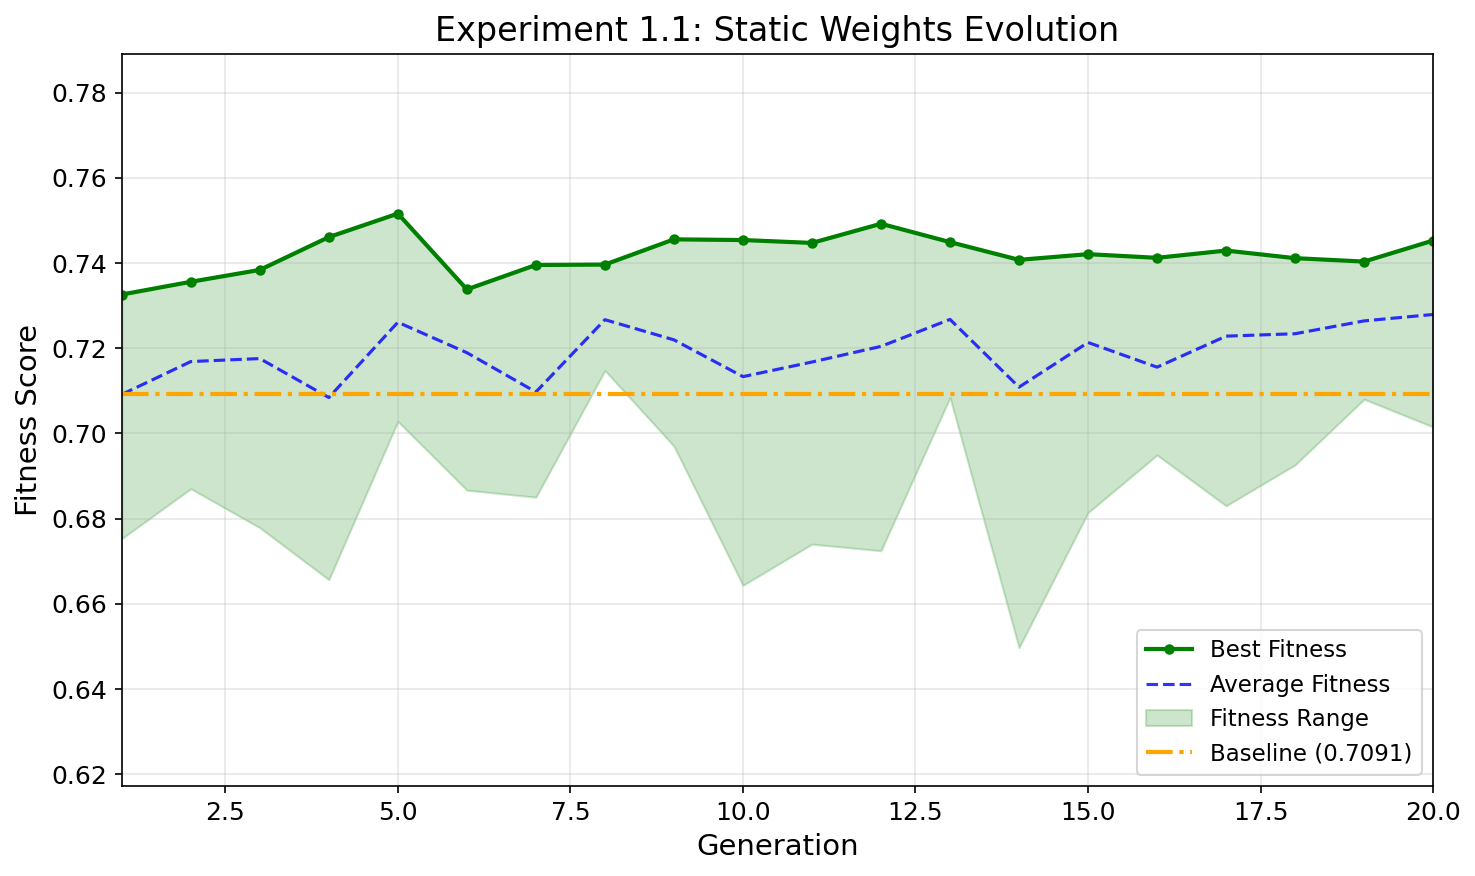

In [7]:
# Visualize static experiment convergence
fig_static = visualize_results(
    static_history, 
    baseline_score,
    title="Experiment 1.1: Static Weights Evolution"
)
fig_static.savefig(OUTPUT_DIR / "exp1_1_convergence.png")
plt.show()

## Cell 7: Run Experiment 1.2 (Adaptive Weights)

In [8]:
print("=" * 60)
print("EXPERIMENT 1.2: ADAPTIVE WEIGHTS")
print(f"CLIP Weight: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"Aesthetic Weight: {1 - INITIAL_CLIP_WEIGHT} -> {1 - FINAL_CLIP_WEIGHT}")
print("Strategy: Start semantic-focused, end aesthetic-focused")
print("=" * 60)

# Re-create adaptive evaluator to reset state
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)

# Run experiment with adaptive weights
adaptive_history, adaptive_population = run_experiment(
    evaluator=adaptive_evaluator,
    experiment_name="exp1_2_adaptive",
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=True
)

# Get best genome from adaptive experiment
best_adaptive_genome = max(adaptive_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.2 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_adaptive_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_adaptive_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_adaptive_genome.negative_modifiers}")
print(f"\nTotal images generated: {len(ALL_RESULTS)}")

EXPERIMENT 1.2: ADAPTIVE WEIGHTS
CLIP Weight: 0.8 -> 0.4
Aesthetic Weight: 0.19999999999999996 -> 0.6
Strategy: Start semantic-focused, end aesthetic-focused
Initializing CLIP model on cpu...
CLIP model loaded successfully
Initializing population of 10 genomes...

--- Generation 1/20 ---
Weights: CLIP=0.80, Aesthetic=0.20


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7004 | Avg: 0.6855 | Diversity: 0.10
Best prompt: a tiger in the jungle, glitch art, airbrush, ultra realistic, unreal engine, vis...

--- Generation 2/20 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7087 | Avg: 0.6901 | Diversity: 0.07
Best prompt: a tiger in the jungle, uplifting composition, airbrush, broad light, unreal engi...

--- Generation 3/20 ---
Weights: CLIP=0.76, Aesthetic=0.24


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7130 | Avg: 0.6977 | Diversity: 0.06
Best prompt: a tiger in the jungle, uplifting composition, airbrush, broad light, color harmo...

--- Generation 4/20 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7115 | Avg: 0.6966 | Diversity: 0.06
Best prompt: a tiger in the jungle, uplifting composition, airbrush, broad light, unreal engi...

--- Generation 5/20 ---
Weights: CLIP=0.72, Aesthetic=0.28


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7159 | Avg: 0.7072 | Diversity: 0.05
Best prompt: a tiger in the jungle, golden ratio...

VOCABULARY EXPANSION (Generation 5)
Added 14 new modifiers
  composition: close-up composition, diagonals, isometric composition, environmental framing
  style: photo realism, retro aesthetic, isometric art, comic book style, impressionism...
  quality: ultra detailed, vivid colors
  negative: mutation, duplicate objects

AFTER EXPANSION:
  composition :  217 modifiers
  lighting    :  221 modifiers
  style       :  283 modifiers
  quality     :  210 modifiers
  negative    :  258 modifiers
  TOTAL       : 1189 modifiers
  Synonym mappings: 52

  Updated vocabulary: 931 positive, 258 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7279 | Avg: 0.7099 | Diversity: 0.05
Best prompt: a tiger in the jungle, premium, airbrush, technical style, crisp lines, bokeh ef...

--- Generation 7/20 ---
Weights: CLIP=0.68, Aesthetic=0.32


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7244 | Avg: 0.7116 | Diversity: 0.06
Best prompt: a tiger in the jungle, premium, airbrush, technical style, crisp lines, bokeh ef...

--- Generation 8/20 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7332 | Avg: 0.7208 | Diversity: 0.06
Best prompt: a tiger in the jungle, isometric, photorealistic, cloudy, maya, retro style, low...

--- Generation 9/20 ---
Weights: CLIP=0.64, Aesthetic=0.36


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7361 | Avg: 0.7174 | Diversity: 0.07
Best prompt: a tiger in the jungle, smooth textures, bokeh effect, vanishing point...

--- Generation 10/20 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7381 | Avg: 0.7153 | Diversity: 0.06
Best prompt: a tiger in the jungle, brutalist architecture, bird's eye view, long shadows, in...

VOCABULARY EXPANSION (Generation 10)
Added 8 new modifiers
  composition: close-up framing, split diopter, long exposure, panorama, dramatic cropping
  style: hyperrealism, comic book art, analog photography

AFTER EXPANSION:
  composition :  222 modifiers
  lighting    :  221 modifiers
  style       :  286 modifiers
  quality     :  210 modifiers
  negative    :  258 modifiers
  TOTAL       : 1197 modifiers
  Synonym mappings: 52

  Updated vocabulary: 939 positive, 258 negative

VOCABULARY PRUNING (Generation 10)
No modifiers pruned

AFTER PRUNING:
  composition :  222 modifiers
  lighting    :  221 modifiers
  style       :  286 modifiers
  quality     :  210 modifiers
  negative    :  258 modifiers
  TOTAL       : 1197 modifiers
  Synonym mappings: 52

Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_10

--- Generation 11

Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7348 | Avg: 0.7156 | Diversity: 0.06
Best prompt: a tiger in the jungle, rim light, realistic texture, technical style, iconic com...

--- Generation 12/20 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7534 | Avg: 0.7259 | Diversity: 0.07
Best prompt: a tiger in the jungle, rim light, realistic texture, technical style, iconic com...

--- Generation 13/20 ---
Weights: CLIP=0.56, Aesthetic=0.44


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7467 | Avg: 0.7303 | Diversity: 0.06
Best prompt: a tiger in the jungle, duotone, golden hour, technical style, iconic composition...

--- Generation 14/20 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7379 | Avg: 0.7159 | Diversity: 0.06
Best prompt: a tiger in the jungle, motion blur lighting, contrasting elements, realistic lig...

--- Generation 15/20 ---
Weights: CLIP=0.52, Aesthetic=0.48


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7706 | Avg: 0.7249 | Diversity: 0.07
Best prompt: a tiger in the jungle, rim light, bloom effect, technical style, matte painting,...

VOCABULARY EXPANSION (Generation 15)
Added 13 new modifiers
  composition: wide-angle shot, Dutch angle, isometric view
  lighting: localized illumination, photorealistic lighting, crepuscular rays
  style: retrowave, maximalism, kinetic art
  quality: ultra-detailed, high-definition, sharp details, professionally rendered

AFTER EXPANSION:
  composition :  225 modifiers
  lighting    :  224 modifiers
  style       :  289 modifiers
  quality     :  214 modifiers
  negative    :  258 modifiers
  TOTAL       : 1210 modifiers
  Synonym mappings: 52

  Updated vocabulary: 952 positive, 258 negative
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7554 | Avg: 0.7266 | Diversity: 0.06
Best prompt: a tiger in the jungle, animation, golden hour, soft style, finely detailed, ligh...

--- Generation 17/20 ---
Weights: CLIP=0.48, Aesthetic=0.52


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7653 | Avg: 0.7402 | Diversity: 0.06
Best prompt: a tiger in the jungle, confined space, illustration, cubism, hard light, sunny, ...

--- Generation 18/20 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7729 | Avg: 0.7462 | Diversity: 0.06
Best prompt: a tiger in the jungle, confined space, illustration, soft texture, cyberpunk, su...

--- Generation 19/20 ---
Weights: CLIP=0.44, Aesthetic=0.56


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7753 | Avg: 0.7475 | Diversity: 0.06
Best prompt: a tiger in the jungle, illustration, telephoto lens, ray tracing, thematic compo...

--- Generation 20/20 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 16:24:23,860 - experiment_1 - INFO - exp1_2_adaptive complete. Best fitness: 0.7776


Best: 0.7776 | Avg: 0.7510 | Diversity: 0.08
Best prompt: a tiger in the jungle, detailed style, over-the-shoulder shot, virtual light, dy...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_20

EXPERIMENT 1.2 RESULTS
Final Best Fitness: 0.7776
Improvement over baseline: 9.66%

Best Prompt:
  a tiger in the jungle, detailed style, over-the-shoulder shot, virtual light, dynamic symmetry, aesthetically pleasing, anamorphic lens, thematic composition, split diopter, overexposed, close-up composition, extreme wide shot, procreate

Positive Modifiers: ['detailed style', 'over-the-shoulder shot', 'virtual light', 'dynamic symmetry', 'aesthetically pleasing', 'anamorphic lens', 'thematic composition', 'split diopter', 'overexposed', 'close-up composition', 'extreme wide shot', 'procreate']
Negative Modifiers: ['washed-out colors', 'unrealistic perspective', 'bad textures', 'grainy', 'disproportionate', 'phony']

Total images generated: 400


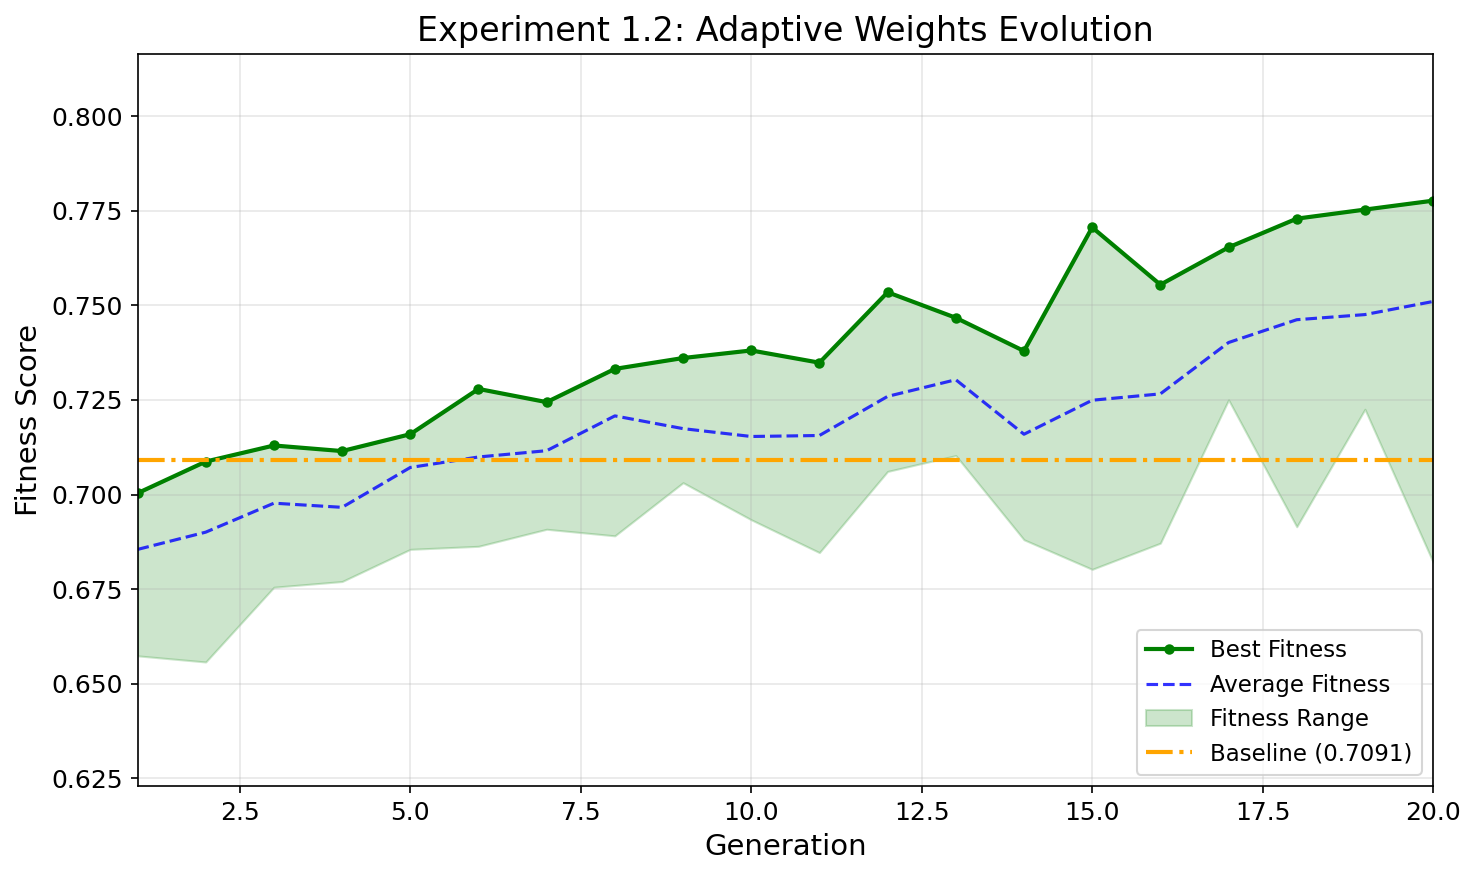

In [9]:
# Visualize adaptive experiment convergence
fig_adaptive = visualize_results(
    adaptive_history, 
    baseline_score,
    title="Experiment 1.2: Adaptive Weights Evolution"
)
fig_adaptive.savefig(OUTPUT_DIR / "exp1_2_convergence.png")
plt.show()

## Cell 8: Comparison & Statistical Analysis

COMPARISON: STATIC vs ADAPTIVE WEIGHTS


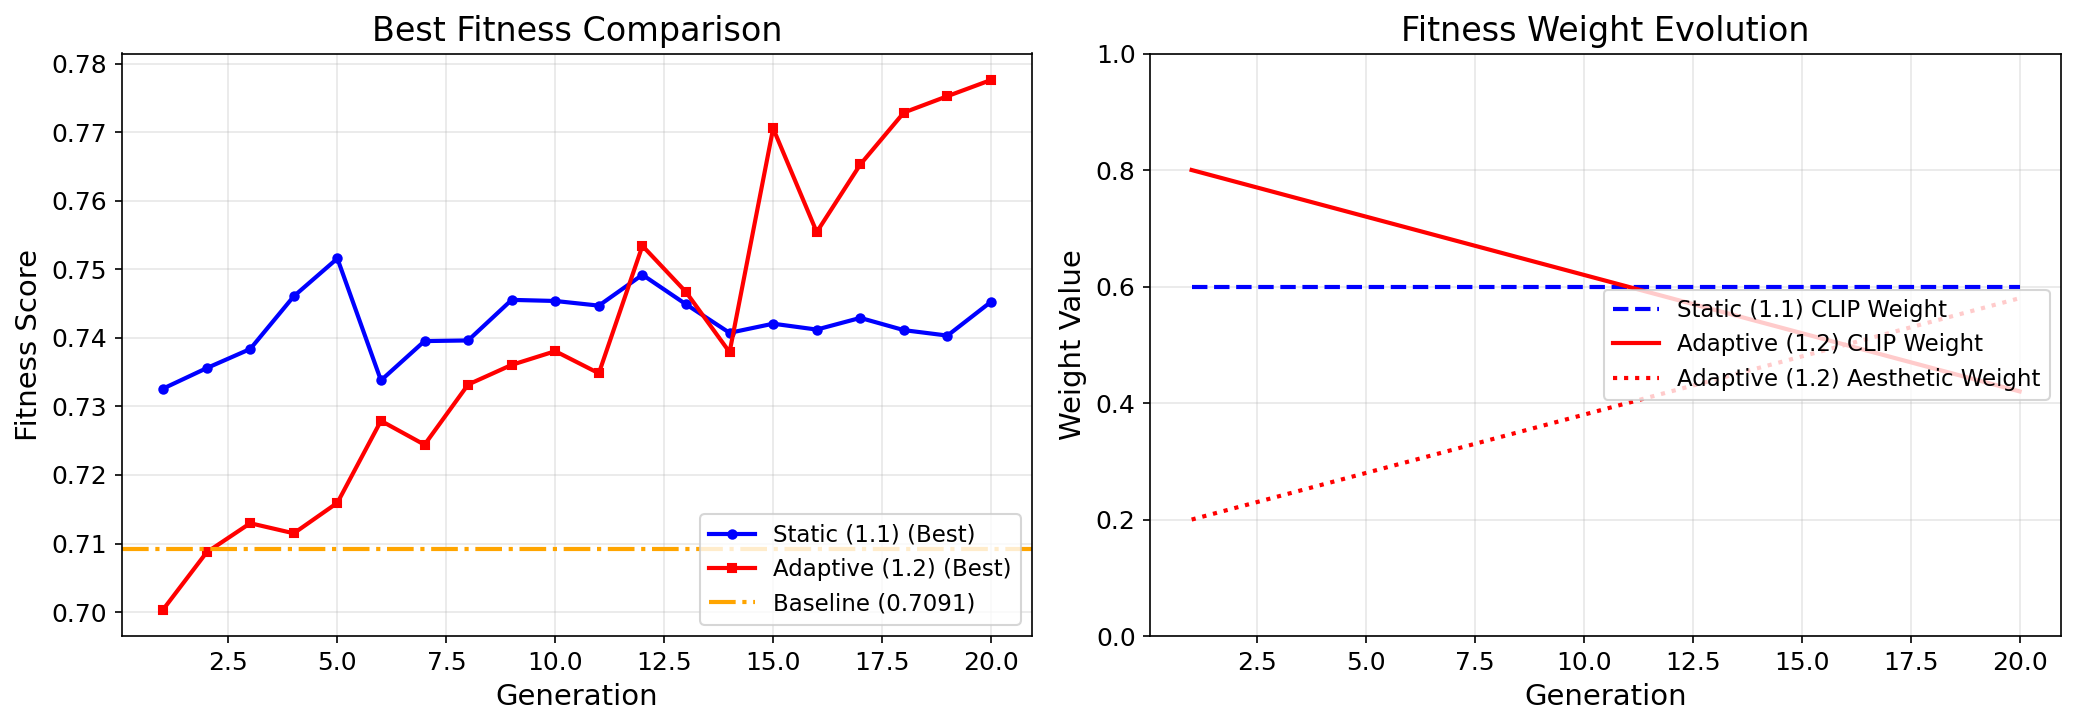


------------------------------------------------------------
STATISTICAL ANALYSIS
------------------------------------------------------------

Independent t-test:
  t-statistic: -2.1802
  p-value: 0.0428
  Significant (p < 0.05): Yes

Mann-Whitney U test:
  U-statistic: 21.0000
  p-value: 0.0312
  Significant (p < 0.05): Yes

------------------------------------------------------------
DESCRIPTIVE STATISTICS
------------------------------------------------------------

Baseline:
  Fitness: 0.7091

Static Weights (Exp 1.1):
  Mean:   0.7279
  Std:    0.0148
  Min:    0.7015
  Max:    0.7453
  Median: 0.7303

Adaptive Weights (Exp 1.2):
  Mean:   0.7510
  Std:    0.0281
  Min:    0.6821
  Max:    0.7776
  Median: 0.7569

Effect Size (Cohen's d): 1.0277
  Interpretation: large effect


In [10]:
print("=" * 60)
print("COMPARISON: STATIC vs ADAPTIVE WEIGHTS")
print("=" * 60)

# Side-by-side convergence comparison
fig_comparison = compare_experiments(
    static_history,
    adaptive_history,
    baseline_score,
    exp1_name="Static (1.1)",
    exp2_name="Adaptive (1.2)"
)
fig_comparison.savefig(OUTPUT_DIR / "comparison_plot.png")
plt.show()

# Extract final fitness values for statistical comparison
static_final = [g.fitness for g in static_population]
adaptive_final = [g.fitness for g in adaptive_population]

# Statistical tests
print("\n" + "-" * 60)
print("STATISTICAL ANALYSIS")
print("-" * 60)

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(static_final, adaptive_final)
print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(static_final, adaptive_final, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if u_pvalue < 0.05 else 'No'}")

# Descriptive statistics
print("\n" + "-" * 60)
print("DESCRIPTIVE STATISTICS")
print("-" * 60)

print(f"\nBaseline:")
print(f"  Fitness: {baseline_score:.4f}")

print(f"\nStatic Weights (Exp 1.1):")
print(f"  Mean:   {np.mean(static_final):.4f}")
print(f"  Std:    {np.std(static_final):.4f}")
print(f"  Min:    {np.min(static_final):.4f}")
print(f"  Max:    {np.max(static_final):.4f}")
print(f"  Median: {np.median(static_final):.4f}")

print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  Mean:   {np.mean(adaptive_final):.4f}")
print(f"  Std:    {np.std(adaptive_final):.4f}")
print(f"  Min:    {np.min(adaptive_final):.4f}")
print(f"  Max:    {np.max(adaptive_final):.4f}")
print(f"  Median: {np.median(adaptive_final):.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(static_final) - 1) * np.var(static_final) + 
                      (len(adaptive_final) - 1) * np.var(adaptive_final)) / 
                     (len(static_final) + len(adaptive_final) - 2))
cohens_d = (np.mean(adaptive_final) - np.mean(static_final)) / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation} effect")

/var/folders/p7/7kcv3ngd7q18v8lpks6vq25r0000gn/T/ipykernel_49285/66451307.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],


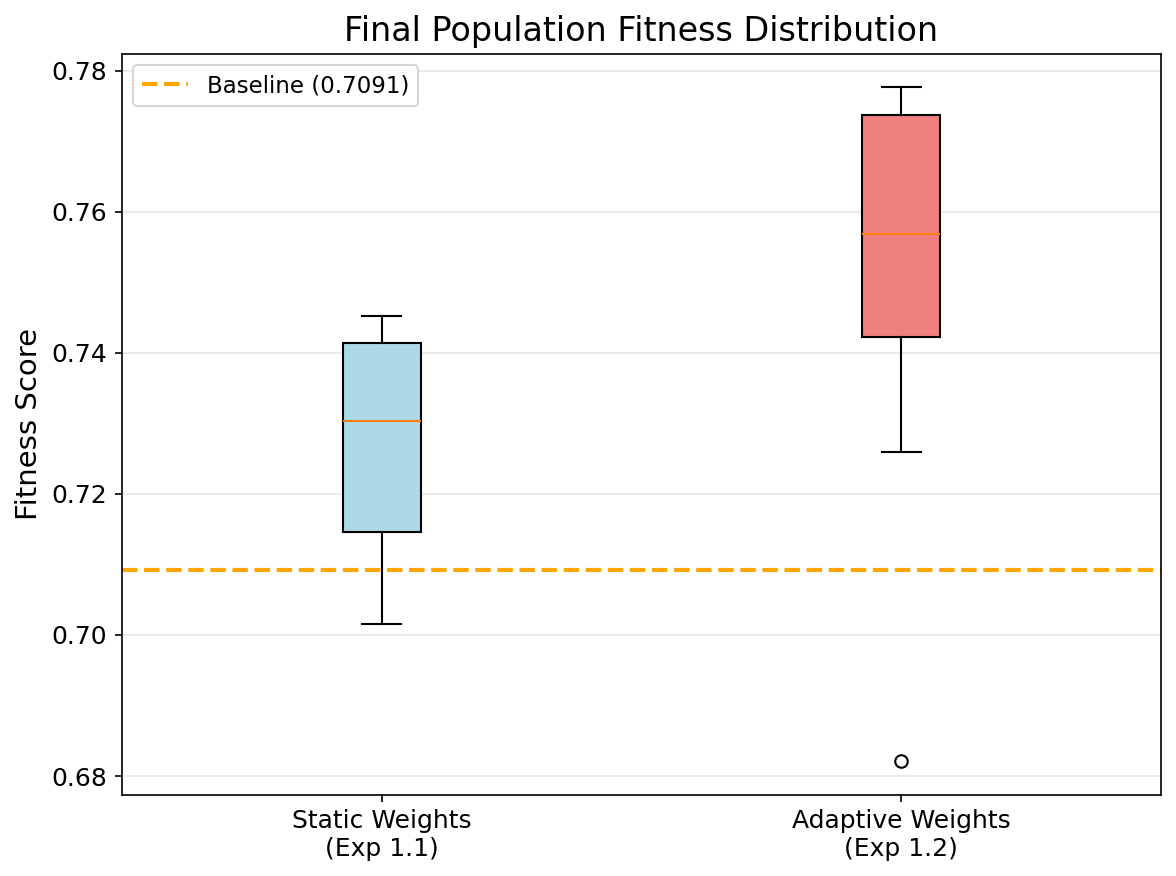

In [11]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = [static_final, adaptive_final]
bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],
                patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')

# Add baseline line
ax.axhline(y=baseline_score, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_score:.4f})')

ax.set_ylabel('Fitness Score')
ax.set_title('Final Population Fitness Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "boxplot_comparison.png")
plt.show()

## Cell 9: Visual Comparison

In [12]:
print("Generating final comparison images...")
print("This may take a moment...\n")

# Generate final images with consistent seed for fair comparison
COMPARISON_SEED = 12345

# Baseline image (already generated, but regenerate with comparison seed)
print("Generating baseline image...")
baseline_final_image, baseline_final_score = generate_final_image(
    factory.create_empty(BASE_PROMPT), 
    seed=COMPARISON_SEED
)

# Best static image
print("Generating best static weights image...")
static_final_image, static_final_score = generate_final_image(
    best_static_genome, 
    seed=COMPARISON_SEED
)

# Best adaptive image  
print("Generating best adaptive weights image...")
adaptive_final_image, adaptive_final_score = generate_final_image(
    best_adaptive_genome, 
    seed=COMPARISON_SEED
)

print("Image generation complete.")

Generating final comparison images...
This may take a moment...

Generating baseline image...
Generating best static weights image...
Generating best adaptive weights image...
Image generation complete.


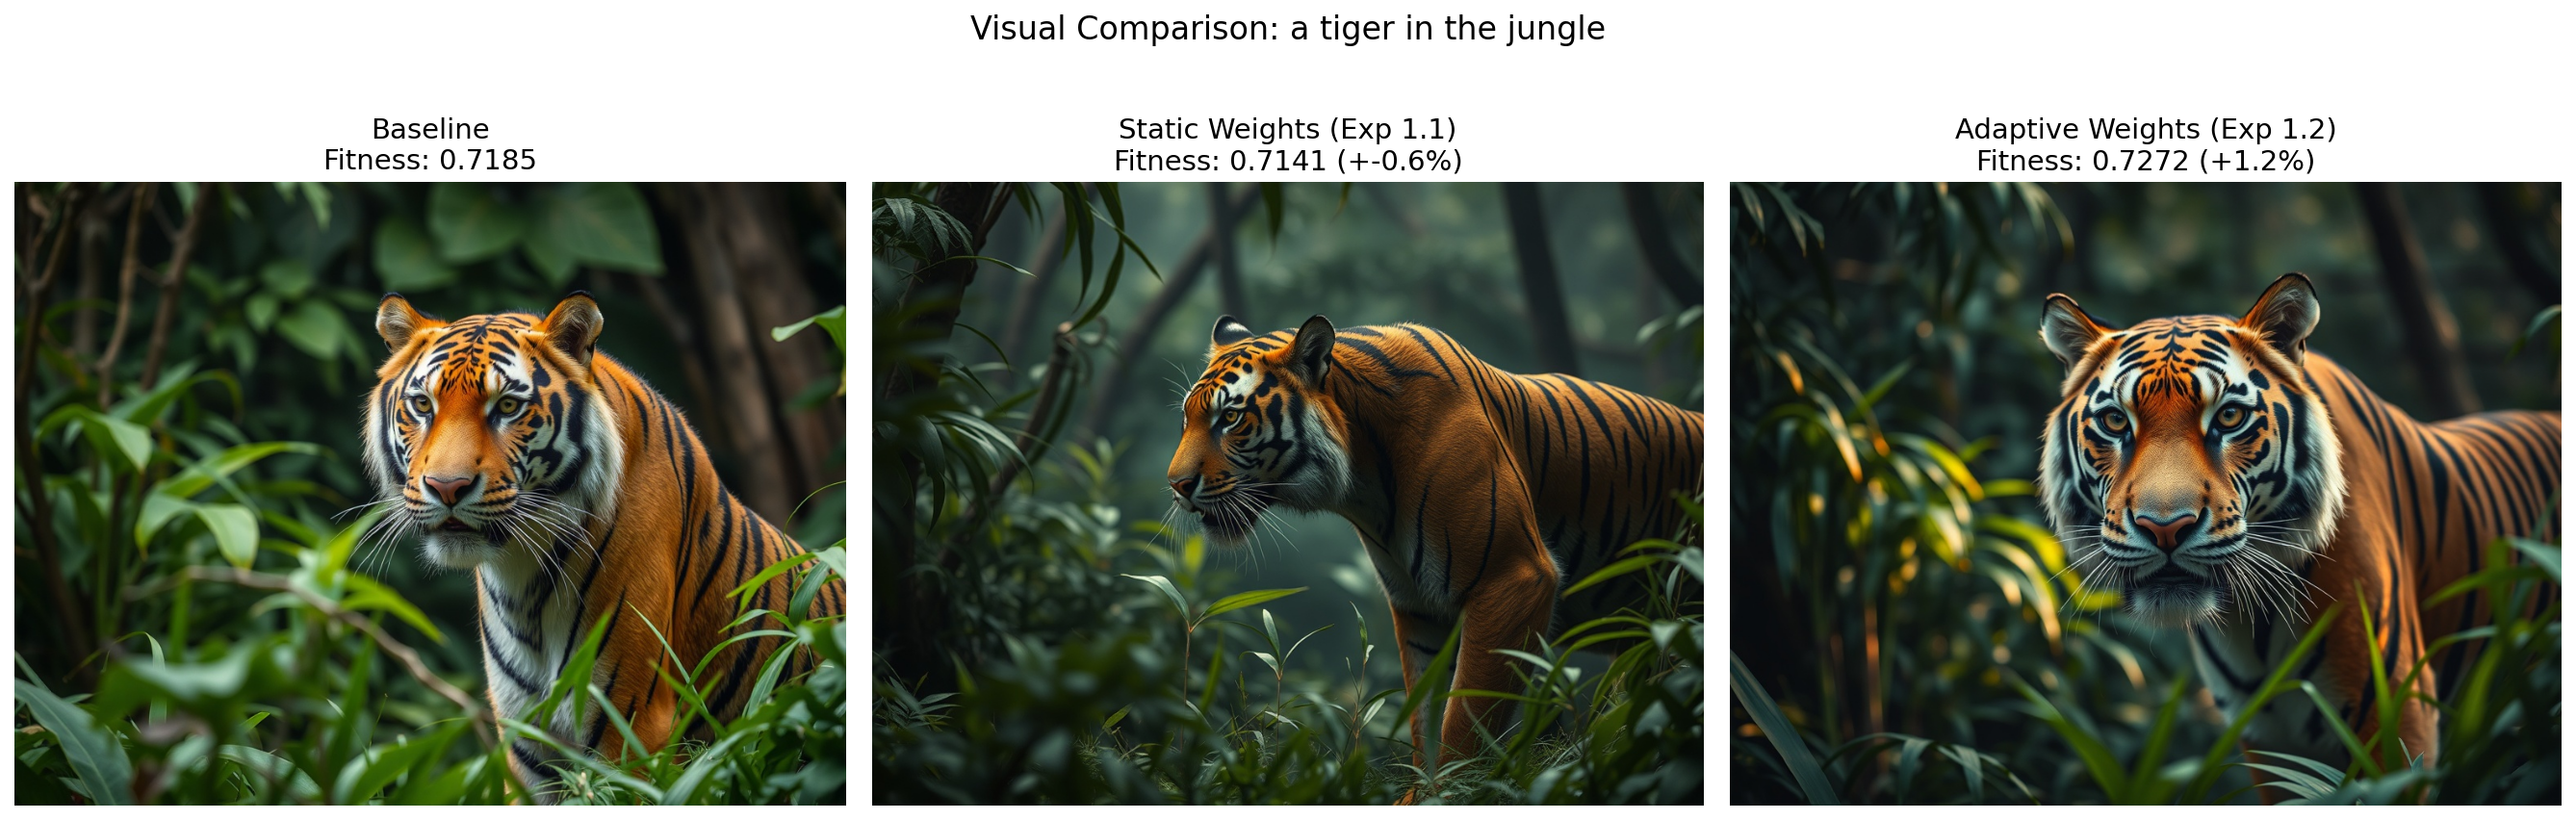


Images saved to output directory.


In [13]:
# Create side-by-side visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Baseline
axes[0].imshow(baseline_final_image)
axes[0].set_title(f"Baseline\nFitness: {baseline_final_score:.4f}", fontsize=14)
axes[0].axis('off')

# Static best
axes[1].imshow(static_final_image)
improvement_static = (static_final_score - baseline_final_score) / baseline_final_score * 100
axes[1].set_title(f"Static Weights (Exp 1.1)\nFitness: {static_final_score:.4f} (+{improvement_static:.1f}%)", fontsize=14)
axes[1].axis('off')

# Adaptive best
axes[2].imshow(adaptive_final_image)
improvement_adaptive = (adaptive_final_score - baseline_final_score) / baseline_final_score * 100
axes[2].set_title(f"Adaptive Weights (Exp 1.2)\nFitness: {adaptive_final_score:.4f} (+{improvement_adaptive:.1f}%)", fontsize=14)
axes[2].axis('off')

plt.suptitle(f"Visual Comparison: {BASE_PROMPT}", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_comparison.png", bbox_inches='tight')
plt.show()

# Save individual images
baseline_final_image.save(OUTPUT_DIR / "final_baseline.jpg")
static_final_image.save(OUTPUT_DIR / "final_static_best.jpg")
adaptive_final_image.save(OUTPUT_DIR / "final_adaptive_best.jpg")

print("\nImages saved to output directory.")

In [14]:
# Print evolved prompts for comparison
print("=" * 60)
print("EVOLVED PROMPTS COMPARISON")
print("=" * 60)

print(f"\nBASELINE PROMPT:")
print(f"  {BASE_PROMPT}")

print(f"\nSTATIC WEIGHTS BEST PROMPT:")
print(f"  {best_static_genome.to_prompt()}")
print(f"  Positive modifiers: {best_static_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_static_genome.negative_modifiers}")

print(f"\nADAPTIVE WEIGHTS BEST PROMPT:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"  Positive modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_adaptive_genome.negative_modifiers}")

EVOLVED PROMPTS COMPARISON

BASELINE PROMPT:
  a tiger in the jungle

STATIC WEIGHTS BEST PROMPT:
  a tiger in the jungle, unreal engine, visually visionary, historical, dynamic composition
  Positive modifiers: ['unreal engine', 'visually visionary', 'historical', 'dynamic composition']
  Negative modifiers: ['bad hands', 'uncreative design', 'decayed', 'unrealistic shading', 'unnatural effects', 'deteriorated']

ADAPTIVE WEIGHTS BEST PROMPT:
  a tiger in the jungle, detailed style, over-the-shoulder shot, virtual light, dynamic symmetry, aesthetically pleasing, anamorphic lens, thematic composition, split diopter, overexposed, close-up composition, extreme wide shot, procreate
  Positive modifiers: ['detailed style', 'over-the-shoulder shot', 'virtual light', 'dynamic symmetry', 'aesthetically pleasing', 'anamorphic lens', 'thematic composition', 'split diopter', 'overexposed', 'close-up composition', 'extreme wide shot', 'procreate']
  Negative modifiers: ['washed-out colors', 'unre

## Cell 10: Export Results for IEEE Paper

In [ ]:
# Compile all results for IEEE paper
print("Compiling results for IEEE paper export...")

# Convert numpy types to Python native types for JSON serialization
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj

# Prepare results dictionary
results = {
    "metadata": {
        "experiment": "1_prompt_enhancement",
        "timestamp": datetime.now().isoformat(),
        "random_seed": RANDOM_SEED,
        "model": MODEL_NAME
    },
    "configuration": {
        "population_size": POPULATION_SIZE,
        "max_generations": MAX_GENERATIONS,
        "elite_size": ELITE_SIZE,
        "mutation_rate": MUTATION_RATE,
        "max_positive_modifiers": MAX_POSITIVE_MODIFIERS,
        "max_negative_modifiers": MAX_NEGATIVE_MODIFIERS
    },
    "baseline": {
        "prompt": BASE_PROMPT,
        "fitness": float(baseline_score)
    },
    "static_weights": {
        "clip_weight": STATIC_CLIP_WEIGHT,
        "aesthetic_weight": STATIC_AESTHETIC_WEIGHT,
        "final_best_fitness": float(max(static_final)),
        "final_avg_fitness": float(np.mean(static_final)),
        "final_std_fitness": float(np.std(static_final)),
        "improvement_percent": float((max(static_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_static_genome.to_prompt(),
        "best_positive_modifiers": best_static_genome.positive_modifiers,
        "best_negative_modifiers": best_static_genome.negative_modifiers,
        "convergence_history": to_native(static_history)
    },
    "adaptive_weights": {
        "initial_clip_weight": INITIAL_CLIP_WEIGHT,
        "final_clip_weight": FINAL_CLIP_WEIGHT,
        "final_best_fitness": float(max(adaptive_final)),
        "final_avg_fitness": float(np.mean(adaptive_final)),
        "final_std_fitness": float(np.std(adaptive_final)),
        "improvement_percent": float((max(adaptive_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_adaptive_genome.to_prompt(),
        "best_positive_modifiers": best_adaptive_genome.positive_modifiers,
        "best_negative_modifiers": best_adaptive_genome.negative_modifiers,
        "convergence_history": to_native(adaptive_history)
    },
    "statistical_tests": {
        "t_test": {
            "t_statistic": float(t_stat),
            "p_value": float(p_value),
            "significant": bool(p_value < 0.05)
        },
        "mann_whitney_u": {
            "u_statistic": float(u_stat),
            "p_value": float(u_pvalue),
            "significant": bool(u_pvalue < 0.05)
        },
        "effect_size": {
            "cohens_d": float(cohens_d),
            "interpretation": effect_interpretation
        }
    },
    "comparison_summary": {
        "winner": "adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "static",
        "static_mean": float(np.mean(static_final)),
        "adaptive_mean": float(np.mean(adaptive_final)),
        "difference": float(np.mean(adaptive_final) - np.mean(static_final)),
        "relative_improvement": float((np.mean(adaptive_final) - np.mean(static_final)) / np.mean(static_final) * 100) if np.mean(static_final) > 0 else 0
    }
}

# Save to JSON
results_path = OUTPUT_DIR / "results_experiment_1.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Print summary for paper
print("\n" + "=" * 60)
print("SUMMARY FOR IEEE PAPER")
print("=" * 60)

print(f"\n1. BASELINE PERFORMANCE")
print(f"   - Fitness: {baseline_score:.4f}")

print(f"\n2. EXPERIMENT 1.1 (STATIC WEIGHTS)")
print(f"   - Best Fitness: {max(static_final):.4f}")
print(f"   - Mean Fitness: {np.mean(static_final):.4f} (+/- {np.std(static_final):.4f})")
print(f"   - Improvement: +{(max(static_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n3. EXPERIMENT 1.2 (ADAPTIVE WEIGHTS)")
print(f"   - Best Fitness: {max(adaptive_final):.4f}")
print(f"   - Mean Fitness: {np.mean(adaptive_final):.4f} (+/- {np.std(adaptive_final):.4f})")
print(f"   - Improvement: +{(max(adaptive_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n4. STATISTICAL SIGNIFICANCE")
print(f"   - t-test p-value: {p_value:.4f} ({'significant' if p_value < 0.05 else 'not significant'})")
print(f"   - Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")

winner = "Adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "Static"
print(f"\n5. CONCLUSION")
print(f"   - Better approach: {winner} Weights")
print(f"   - Difference in mean fitness: {abs(np.mean(adaptive_final) - np.mean(static_final)):.4f}")

In [ ]:
# Generate LaTeX table for paper
print("\n" + "=" * 60)
print("LaTeX TABLE FOR IEEE PAPER")
print("=" * 60)

latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Experiment 1: Prompt Enhancement Results}
\label{tab:exp1_results}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{Baseline} & \textbf{Static} & \textbf{Adaptive} \\
\hline
Best Fitness & %.4f & %.4f & %.4f \\
Mean Fitness & - & %.4f & %.4f \\
Std Dev & - & %.4f & %.4f \\
Improvement (\%%) & - & +%.2f\%% & +%.2f\%% \\
\hline
\multicolumn{4}{l}{\textit{Statistical Test: t=%.4f, p=%.4f}} \\
\multicolumn{4}{l}{\textit{Effect Size: Cohen's d=%.4f (%s)}} \\
\hline
\end{tabular}
\end{table}
""" % (
    baseline_score, max(static_final), max(adaptive_final),
    np.mean(static_final), np.mean(adaptive_final),
    np.std(static_final), np.std(adaptive_final),
    (max(static_final) - baseline_score) / baseline_score * 100,
    (max(adaptive_final) - baseline_score) / baseline_score * 100,
    t_stat, p_value, cohens_d, effect_interpretation
)

print(latex_table)

# Save LaTeX table
with open(OUTPUT_DIR / "table_experiment_1.tex", 'w') as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to: {OUTPUT_DIR / 'table_experiment_1.tex'}")

In [ ]:
# Final summary
print("\n" + "=" * 60)
print("EXPERIMENT 1 COMPLETE")
print("=" * 60)

print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for f in sorted(OUTPUT_DIR.glob("*")):
    if f.is_file():
        print(f"  - {f.name}")

print("\nExperiment subdirectories:")
for d in sorted(OUTPUT_DIR.glob("exp*")):
    if d.is_dir():
        print(f"  - {d.name}/")

logger.info("Experiment 1 completed successfully.")
print("\nDone!")

## Cell 11: Return All Results Array

In [ ]:
# =============================================================================
# ALL RESULTS ARRAY
# =============================================================================
# This cell returns the complete results array with all generated images,
# prompts, and fitness scores.

print("=" * 60)
print("ALL RESULTS ARRAY")
print("=" * 60)

print(f"\nTotal entries in ALL_RESULTS: {len(ALL_RESULTS)}")

# Save ALL_RESULTS to JSON file
all_results_path = OUTPUT_DIR / "all_results_array.json"
save_json(ALL_RESULTS, str(all_results_path))
print(f"All results saved to: {all_results_path}")

# Display summary statistics
exp1_1_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp1_1_static']
exp1_2_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp1_2_adaptive']

print(f"\nExperiment 1.1 (Static): {len(exp1_1_results)} images")
print(f"Experiment 1.2 (Adaptive): {len(exp1_2_results)} images")

# Get top 10 results by fitness across all experiments
sorted_results = sorted(ALL_RESULTS, key=lambda x: x['fitness'], reverse=True)
print("\n" + "-" * 60)
print("TOP 10 RESULTS BY FITNESS:")
print("-" * 60)
for i, result in enumerate(sorted_results[:10], 1):
    print(f"\n{i}. Fitness: {result['fitness']:.4f}")
    print(f"   Experiment: {result['experiment']}")
    print(f"   Generation: {result['generation']}")
    print(f"   Prompt: {result['prompt'][:80]}...")
    print(f"   Image: {result['image_path'].split('/')[-1] if result['image_path'] else 'N/A'}")

# Display the array structure
print("\n" + "-" * 60)
print("ARRAY STRUCTURE (sample entry):")
print("-" * 60)
if ALL_RESULTS:
    sample = ALL_RESULTS[0]
    for key, value in sample.items():
        if isinstance(value, list):
            print(f"  {key}: {value[:3]}..." if len(value) > 3 else f"  {key}: {value}")
        elif isinstance(value, str) and len(value) > 50:
            print(f"  {key}: {value[:50]}...")
        else:
            print(f"  {key}: {value}")

print("\n" + "=" * 60)
print("ACCESS ALL_RESULTS VARIABLE FOR FULL DATA")
print("=" * 60)

In [ ]:
# Return ALL_RESULTS array for programmatic access
# This cell outputs the complete array containing all experimental data

ALL_RESULTS